In [38]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import librosa
import IPython.display as ipd
import os, glob
from librosa.feature import rms, zero_crossing_rate, mfcc
from reservoirpy.nodes import Reservoir, ESN, Ridge
from tqdm import tqdm
from numpy import hanning 
from numpy.fft import fft, fftshift

#### Importing and pre-processing data

In [2]:
input_dir = './dataset/ESC-10'
subdirs = os.listdir(input_dir)
subdirs.sort()
labels = []
data = []
sample_rate = 22050
for label ,folder in tqdm(enumerate(subdirs), desc='Loading data', total=len(subdirs)):
    for file in glob.glob(input_dir + '/' + folder + '/*.ogg'):
        x = librosa.load(file, sr=sample_rate)[0]
        labels.append(label)
        data.append(x)

Loading data: 100%|██████████| 10/10 [00:02<00:00,  3.70it/s]


### Sample data and Time feature visualization

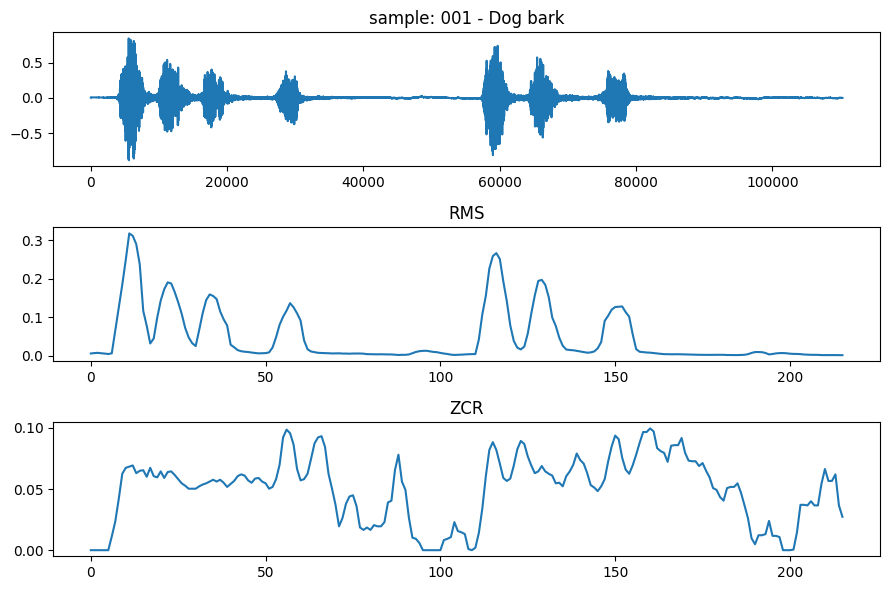

In [43]:
fig , ax = plt.subplots(nrows=3, ncols=1,figsize=(9,6))
ax[0].plot(data[10])
ax[0].set_title('sample: ' + subdirs[labels[10]])
ax[1].plot(rms(y=data[10]).reshape(-1,1))
ax[1].set_title('RMS')
ax[2].plot(zero_crossing_rate(y=data[10]).reshape(-1,1))
ax[2].set_title('ZCR')
plt.tight_layout()
plt.show()

### MFCC

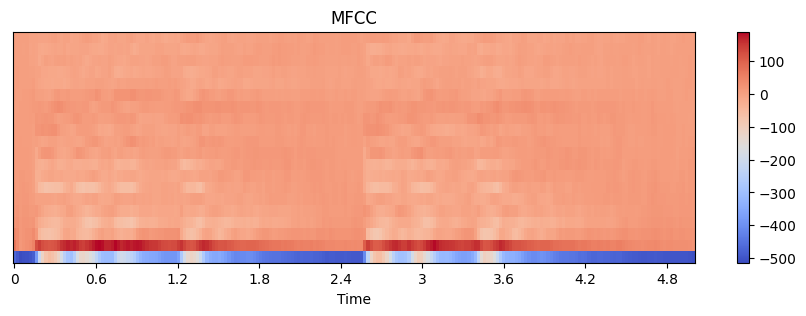

In [78]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(11,3))
mfccs =mfcc(y=data[10], sr=sample_rate)
img = librosa.display.specshow(mfccs, x_axis='time', ax=ax)
fig.colorbar(img, ax=ax)
plt.title('MFCC')
plt.show()

#### Window

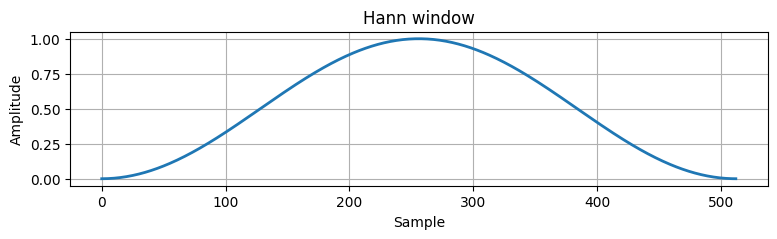

In [87]:
window = hanning(513)
plt.figure(figsize=(9,2))
plt.plot(window, label="Hann window", linewidth=2)
plt.title("Hann window")
plt.ylabel("Amplitude")
plt.xlabel("Sample")
plt.grid()
plt.show()

## ESN Reservoir

In [35]:
reservoir = Reservoir(100, lr=0.5, sr=0.9)
ridge = Ridge(ridge=1e-7)
esn_model = reservoir >> ridge

